In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb

In [2]:
from utils.preprocessing import df_to_xy
#fix rnd seed
np.random.seed(7)

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")

x, y = df_to_xy(df, fuse_risk=True)
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 2/5, random_state = 0)

**Loss function**

In [3]:
@np.vectorize
def sigmoid1024(x):
    base = 2000.0**2
    return (base**x/(base**x + 1))

@np.vectorize
def loss(x):
    offset = 1
    x1 = (x + offset) / 16.0
    x2 = (x) / 40.0
    return (1 - sigmoid1024(x1) *  np.cos(x2/np.pi))

def gain(x):
    return 1 - loss(x)

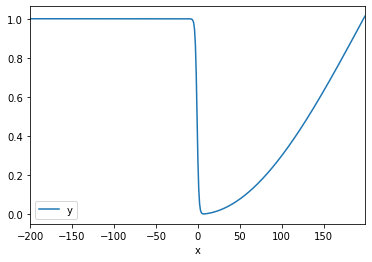

In [4]:
x = np.arange(-200, 200, 1)
y = loss(x)

out_df = pd.DataFrame({'x':x, 'y':y})
out_df.plot.line(x='x', y='y')

In [5]:
from utils.data_augmentation import DACombine

In [6]:
from models.deep import keras_hiddenless_model, keras_model, loss_tf, gain_tf, KerasModel
from keras import backend as K

Using TensorFlow backend.


**Metrics**

In [7]:
from models.metrics import gain_mean, avg_gain_ratio

**Model: No data Augmentation**

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


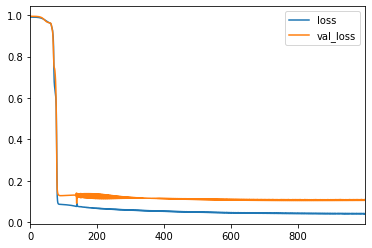

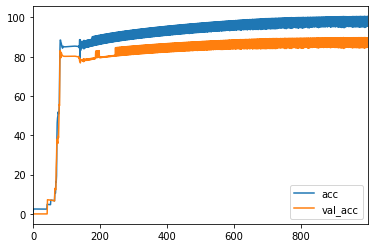

In [8]:
model = KerasModel(loss=loss_tf, metrics=[gain_tf], batch_size=256, epochs=1000)
da = DACombine()
xTrain_a, yTrain_a = xTrain.astype(K.floatx()), yTrain.astype(K.floatx())
split = int(xTrain.shape[1] * 0.75)
#xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
#xTrain_a, yTrain_a = da.fit_predict(xTrain, yTrain, size=1024, distance=10)
history = model.fit(xTrain_a.astype(K.floatx()), yTrain_a.astype(K.floatx()),  validation_split=0.25, verbose=0)

#print(history.history)

loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot()

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot()

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  83.8979042371114
gain_ratio:  0.6830946236334594


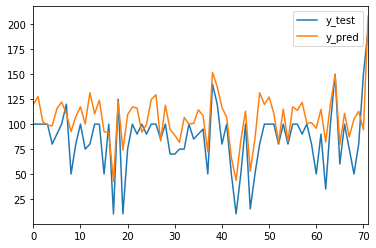

In [9]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

**Model with data augmentation**

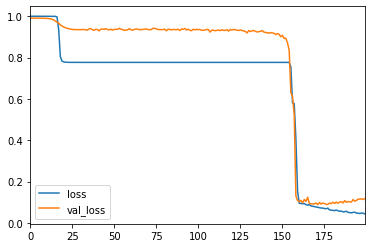

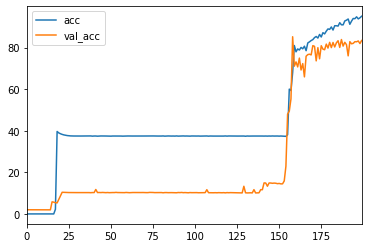

In [10]:
#sci-kit like training
model = KerasModel(loss=loss_tf, metrics=[gain_tf], batch_size=30, epochs=200)
da = DACombine()
xTrain_a, yTrain_a = xTrain, yTrain
split = int(xTrain.shape[1] * 0.75)
xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
xTrain_a, yTrain_a = da.fit_predict(xTrain_a, yTrain_a, size=xTrain_a.shape[1]*16, distance=10, retarget=True, distribution=True, combine=True)
history = model.fit(xTrain_a.astype('float'), yTrain_a.astype('float'),  validation_data=(xVal, yVal), verbose=0)
loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot()

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot()

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  80.25121021270752
gain_ratio:  0.682638504168991


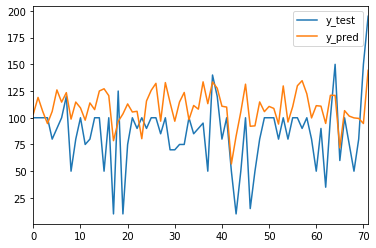

In [11]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

** Model using _mse_ loss and data augmentation**

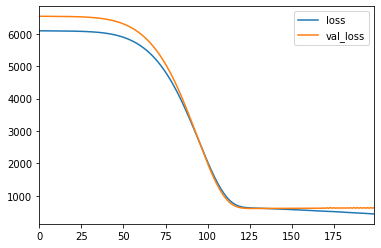

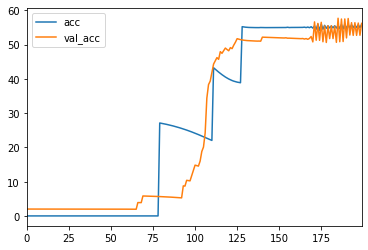

In [12]:
#sci-kit like training
model = KerasModel(loss='mse', metrics=[gain_tf], batch_size=60, epochs=200)
da = DACombine()
split = int(xTrain.shape[1] * 0.75)
xTrain_a, yTrain_a = xTrain[:split], yTrain[:split]
xVal, yVal = xTrain[split:], yTrain[split:]
#xTrain_a, yTrain_a = da.fit_predict(xTrain_a, yTrain_a, size=xTrain_a.shape[1]*16, distance=10, retarget=True, distribution=True, combine=True)
history = model.fit(xTrain_a.astype('float'), yTrain_a.astype('float'), validation_data=(xVal, yVal))
loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot()

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot()

yPred = model.predict(xTest, batch_size=128)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
#stl = model.score(xTest, yTest, verbose=0)

gain_mean:  38.77777777777778
gain_ratio:  0.2768323715560558


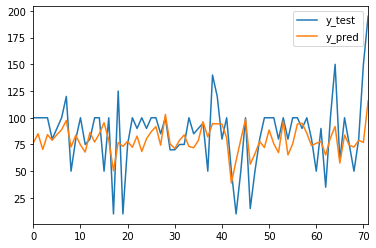

In [13]:
yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot()

yPred = model.predict(xTest)
print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

**CMP Model**

Train on 85 samples, validate on 22 samples
Epoch 1/200
85/85 [==============================] - 0s 5ms/step - loss: 0.9891 - gain_tf: 2.3528 - val_loss: 1.0000 - val_gain_tf: 0.0000e+00
Epoch 2/200
85/85 [==============================] - 0s 139us/step - loss: 0.9883 - gain_tf: 2.3493 - val_loss: 1.0000 - val_gain_tf: 0.0000e+00
Epoch 3/200
85/85 [==============================] - 0s 127us/step - loss: 0.9876 - gain_tf: 2.3460 - val_loss: 1.0000 - val_gain_tf: 0.0000e+00
Epoch 4/200
85/85 [==============================] - 0s 156us/step - loss: 0.9868 - gain_tf: 2.3426 - val_loss: 1.0000 - val_gain_tf: 0.0000e+00
Epoch 5/200
85/85 [==============================] - 0s 135us/step - loss: 0.9860 - gain_tf: 2.3391 - val_loss: 1.0000 - val_gain_tf: 0.0000e+00
Epoch 6/200
85/85 [==============================] - 0s 154us/step - loss: 0.9851 - gain_tf: 2.3355 - val_loss: 1.0000 - val_gain_tf: 0.0000e+00
Epoch 7/200
85/85 [==============================] - 0s 160us/step - loss: 0.9841 - gain

Epoch 58/200
85/85 [==============================] - 0s 158us/step - loss: 0.5512 - gain_tf: 53.9318 - val_loss: 0.6156 - val_gain_tf: 44.1826
Epoch 59/200
85/85 [==============================] - 0s 183us/step - loss: 0.4643 - gain_tf: 63.7227 - val_loss: 0.5340 - val_gain_tf: 51.7594
Epoch 60/200
85/85 [==============================] - 0s 140us/step - loss: 0.3620 - gain_tf: 71.0611 - val_loss: 0.4575 - val_gain_tf: 53.6410
Epoch 61/200
85/85 [==============================] - 0s 152us/step - loss: 0.2475 - gain_tf: 81.2284 - val_loss: 0.3109 - val_gain_tf: 68.5062
Epoch 62/200
85/85 [==============================] - 0s 143us/step - loss: 0.1474 - gain_tf: 90.5037 - val_loss: 0.2314 - val_gain_tf: 80.2983
Epoch 63/200
85/85 [==============================] - 0s 161us/step - loss: 0.1208 - gain_tf: 88.7731 - val_loss: 0.1988 - val_gain_tf: 83.2315
Epoch 64/200
85/85 [==============================] - 0s 140us/step - loss: 0.1098 - gain_tf: 88.1621 - val_loss: 0.1815 - val_gain_tf: 

Epoch 115/200
85/85 [==============================] - 0s 153us/step - loss: 0.0777 - gain_tf: 86.1656 - val_loss: 0.1534 - val_gain_tf: 75.4341
Epoch 116/200
85/85 [==============================] - 0s 143us/step - loss: 0.0772 - gain_tf: 86.1481 - val_loss: 0.1532 - val_gain_tf: 75.3778
Epoch 117/200
85/85 [==============================] - 0s 139us/step - loss: 0.0767 - gain_tf: 86.1239 - val_loss: 0.1529 - val_gain_tf: 75.3168
Epoch 118/200
85/85 [==============================] - 0s 137us/step - loss: 0.0762 - gain_tf: 86.0957 - val_loss: 0.1525 - val_gain_tf: 75.2599
Epoch 119/200
85/85 [==============================] - 0s 145us/step - loss: 0.0756 - gain_tf: 86.0734 - val_loss: 0.1521 - val_gain_tf: 75.2166
Epoch 120/200
85/85 [==============================] - 0s 157us/step - loss: 0.0750 - gain_tf: 86.0677 - val_loss: 0.1518 - val_gain_tf: 75.1956
Epoch 121/200
85/85 [==============================] - 0s 161us/step - loss: 0.0744 - gain_tf: 86.0878 - val_loss: 0.1514 - val_ga

Epoch 172/200
85/85 [==============================] - 0s 157us/step - loss: 0.0618 - gain_tf: 89.1166 - val_loss: 0.1405 - val_gain_tf: 83.4427
Epoch 173/200
85/85 [==============================] - 0s 131us/step - loss: 0.0611 - gain_tf: 92.4094 - val_loss: 0.1306 - val_gain_tf: 80.5331
Epoch 174/200
85/85 [==============================] - 0s 148us/step - loss: 0.0615 - gain_tf: 89.2156 - val_loss: 0.1398 - val_gain_tf: 83.4917
Epoch 175/200
85/85 [==============================] - 0s 154us/step - loss: 0.0608 - gain_tf: 92.5043 - val_loss: 0.1304 - val_gain_tf: 80.5845
Epoch 176/200
85/85 [==============================] - 0s 153us/step - loss: 0.0612 - gain_tf: 89.3134 - val_loss: 0.1391 - val_gain_tf: 83.5404
Epoch 177/200
85/85 [==============================] - 0s 167us/step - loss: 0.0605 - gain_tf: 92.5982 - val_loss: 0.1301 - val_gain_tf: 80.6336
Epoch 178/200
85/85 [==============================] - 0s 145us/step - loss: 0.0609 - gain_tf: 89.4082 - val_loss: 0.1384 - val_ga

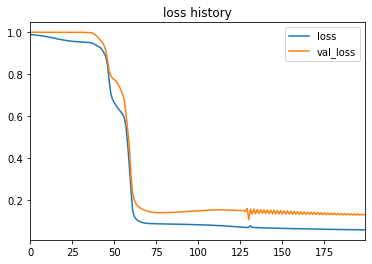

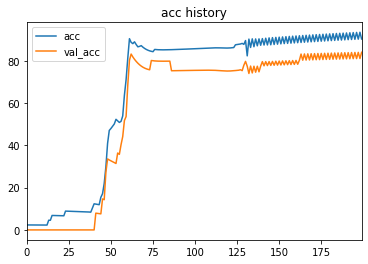

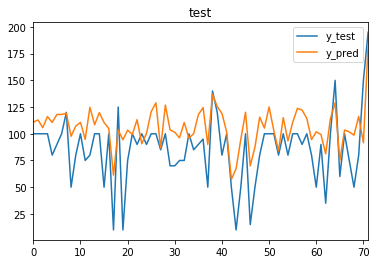

In [14]:
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout, ActivityRegularization


drop_rate = 0.015
model = Sequential()
model.add(Dense(10240, activation='relu', input_shape=(xTrain.shape[1],)))
#model.add(Dropout(rate=drop_rate))
#model.add(Dropout(rate=drop_rate))
model.add(Dense(1024, activation='relu'))
#model.add(Dropout(rate=drop_rate))
model.add(Dense(100, activation='relu'))
#model.add(Dropout(rate=drop_rate))
model.add(Dense(1, activation='linear'))
model.compile(loss=loss_tf,
              optimizer=RMSprop(lr=0.0001),
              metrics=[gain_tf])

history = model.fit(xTrain, yTrain, epochs=200, verbose=1, batch_size=512, validation_split=0.20)

loss_hist = pd.DataFrame(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']})
loss_hist.plot(title="loss history")

acc_hist = pd.DataFrame(data={'acc': history.history['gain_tf'], 'val_acc': history.history['val_gain_tf']})
acc_hist.plot(title="acc history")

yPred = model.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot(title="test")

yPred = model.predict(xTest)
print("train gain: ", gain_mean(yTrain.ravel(), model.predict(xTrain).ravel()))
print("train gain_ratio: ", avg_gain_ratio(yTrain.ravel(), model.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

In [32]:
from notebooks.models import AcceptanceModel
from notebooks.utils.data_augmentation import DASampling


drop_rate = 0.15
model = Sequential()
model.add(Dense(2000, activation='relu', input_shape=(11,)))
#model.add(Dropout(rate=drop_rate))
model.add(Dense(275, activation='relu'))
model.add(Dense(275, activation='relu'))
model.add(Dense(275, activation='relu'))
model.add(Dense(275, activation='relu'))
model.add(Dense(275, activation='relu'))
model.add(Dense(275, activation='relu'))
model.add(Dense(275, activation='relu'))
model.add(Dense(275, activation='relu'))
model.add(Dense(275, activation='relu'))
model.add(Dense(275, activation='relu'))
model.add(Dense(275, activation='relu'))
model.add(Dense(275, activation='relu'))
model.add(Dense(275, activation='relu'))
model.add(Dense(275, activation='relu'))
#model.add(Dropout(rate=drop_rate))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss="mse",
              optimizer='rmsprop',#optimizer=RMSprop(lr=0.0001),
              metrics=[gain_tf])
amodel = AcceptanceModel(model)
axTrain, ayTrain = DASampling().generate_data(xTrain, yTrain, 10000)
amodel.fit(
    axTrain,
    ayTrain,
    fit_kwargs={
        "epochs": 16,
        "batch_size": 10240,
        "validation_split": 0.2,
        "verbose": 1
    }
)
# amodel.fit(
#     xTrain,
#     yTrain,
#     fit_kwargs={
#         "epochs": 8,
#         "batch_size": 10000,
#         #"validation_split": 0.2,
#         "verbose":1
#     }
# )

yPred = amodel.predict(xTest, predict_kwargs={"batch_size": 10000})

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot(title="test")

yPred = amodel.predict(xTest)
print("train gain: ", gain_mean(yTrain.ravel(), amodel.predict(xTrain).ravel()))
print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), amodel.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

Train on 328000 samples, validate on 82000 samples
Epoch 1/16
328000/328000 [==============================] - 3s 8us/step - loss: 0.9776 - gain_tf: 74.1737 - val_loss: 1.0000 - val_gain_tf: 73.3610
Epoch 2/16
328000/328000 [==============================] - 1s 4us/step - loss: 0.8860 - gain_tf: 74.1916 - val_loss: 0.5247 - val_gain_tf: 73.3372
Epoch 3/16
328000/328000 [==============================] - 2s 5us/step - loss: 0.5527 - gain_tf: 74.1999 - val_loss: 0.5257 - val_gain_tf: 73.3557
Epoch 4/16
328000/328000 [==============================] - 1s 5us/step - loss: 0.5371 - gain_tf: 74.2043 - val_loss: 0.5718 - val_gain_tf: 73.3017
Epoch 5/16
328000/328000 [==============================] - 2s 5us/step - loss: 0.5322 - gain_tf: 74.4096 - val_loss: 0.5182 - val_gain_tf: 93.6153
Epoch 6/16
328000/328000 [==============================] - 2s 5us/step - loss: 0.5274 - gain_tf: 76.9067 - val_loss: 0.5833 - val_gain_tf: 73.3601
Epoch 7/16
328000/328000 [==============================] - 2

KeyboardInterrupt: 

train gain:  93.92523364485982
train gain_ratio 0.7750138622467448
gain_mean:  88.47222222222223
gain_ratio:  0.7609395094935714


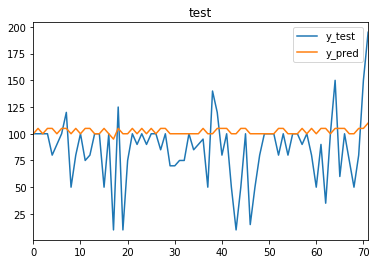

In [42]:
axTrain, ayTrain = DASampling().generate_data(xTrain, yTrain, 1000)
aamodel = AcceptanceModel.get_trained_model(xTrain=axTrain, yTrain=ayTrain)

yPred = aamodel.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot(title="test")

yPred = aamodel.predict(xTest)
print("train gain: ", gain_mean(yTrain.ravel(), aamodel.predict(xTrain).ravel()))
print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), aamodel.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

train gain:  92.5233644859813
train gain_ratio 0.7586820489847392
gain_mean:  83.54166666666667
gain_ratio:  0.7063686377888323


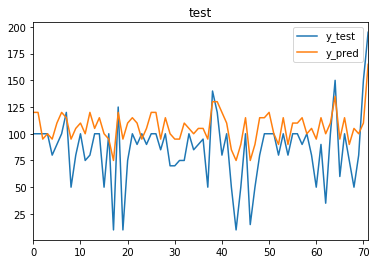

In [47]:
aamodel.fit(xTrain, yTrain)
yPred = aamodel.predict(xTest)

out_data = pd.DataFrame(data={'y_test': np.ravel(yTest), 'y_pred': np.ravel(yPred)})
out_data.plot(title="test")

yPred = aamodel.predict(xTest)
print("train gain: ", gain_mean(yTrain.ravel(), aamodel.predict(xTrain).ravel()))
print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), aamodel.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

In [17]:
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, RandomForestClassifier, BaggingClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor

model = RandomForestClassifier(
    n_estimators=256,
    criterion="entropy",
    #min_samples_split=3,
    #bootstrap_features=True,
    n_jobs=8
)
model = MLPClassifier(
    #hidden_layer_sizes=(1024, 1024,),
    #hidden_layer_sizes=(256, 256, 256, ),
    hidden_layer_sizes=(1024, 1024),
    solver='sgd',
    max_iter=512,
    batch_size=xTrain.shape[1],
    learning_rate='adaptive',
#     early_stopping=True,
#     n_iter_no_change=128
)
model.fit(xTrain, yTrain.ravel())

yPred = model.predict(xTest)

print("train gain: ", gain_mean(yTrain.ravel(), model.predict(xTrain).ravel()))
print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), model.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

train gain:  94.29906542056075
train gain_ratio 0.7514178704525671
gain_mean:  71.80555555555556
gain_ratio:  0.5917185281658965


/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (512) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [34]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'learning_rate': ['constant', 'adaptive'],
    'batch_size': ['auto', 512],
    'learning_rate_init': [0.001, 0.0001, 0.00001]
}

model = MLPClassifier(
    #hidden_layer_sizes=(1024, 1024,),
    #hidden_layer_sizes=(256, 256, 256, ),
    hidden_layer_sizes=(1024,),
    solver='sgd',
    max_iter=512,
    batch_size=xTrain.shape[1],
    learning_rate='adaptive',
#     early_stopping=True,
#     n_iter_no_change=128
)
clf = GridSearchCV(model, parameters, cv=3,)

clf.fit(xTrain, yTrain.ravel())

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (512) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (512) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer

/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (512) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:351: UserWarning: Got `batch_size` less than 1 or larger than sample size. It is going to be clipped
  warnings.warn("Got `batch_size` less than 1 or larger than "
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (512) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:351: UserWarning: Got `batch_size` less than 1 or larger than sample

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size=10, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1024,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=512, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='sgd', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': ['constant', 'adaptive'], 'batch_size': ['auto', 512], 'learning_rate_init': [0.001, 0.0001, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [37]:

yPred = clf.predict(xTest)

print("train gain: ", gain_mean(yTrain.ravel(), clf.predict(xTrain).ravel()))
print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), clf.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

train gain:  95.32710280373831
train gain_ratio 0.7823393587174059
gain_mean:  91.66666666666667
gain_ratio:  0.7854746829289163


In [38]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

m_pca = PCA(n_components=2)
model = MLPClassifier(
    hidden_layer_sizes=(1024,),
    solver='sgd',
    max_iter=1024,
    batch_size=xTrain.shape[1],
    learning_rate='adaptive',
    activation='relu',
)
p = Pipeline([('pca', m_pca), ('mlp', model)])
p.fit(xTrain, yTrain.ravel())
yPred = p.predict(xTest)

print("train gain: ", gain_mean(yTrain.ravel(), p.predict(xTrain).ravel()))
print("train gain_ratio", avg_gain_ratio(yTrain.ravel(), p.predict(xTrain).ravel()))

print("gain_mean: ", gain_mean(yTest.ravel(), yPred.ravel()))
print("gain_ratio: ", avg_gain_ratio(yTest.ravel(), yPred.ravel()))

train gain:  88.3177570093458
train gain_ratio 0.7043019391630008
gain_mean:  78.47222222222223
gain_ratio:  0.6593822367277745


/home/franck/anaconda3/envs/thesis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1024) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
